<a href="https://colab.research.google.com/github/Raphael181/Raphael181/blob/main/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import os
import random
%tensorflow_version 2.x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


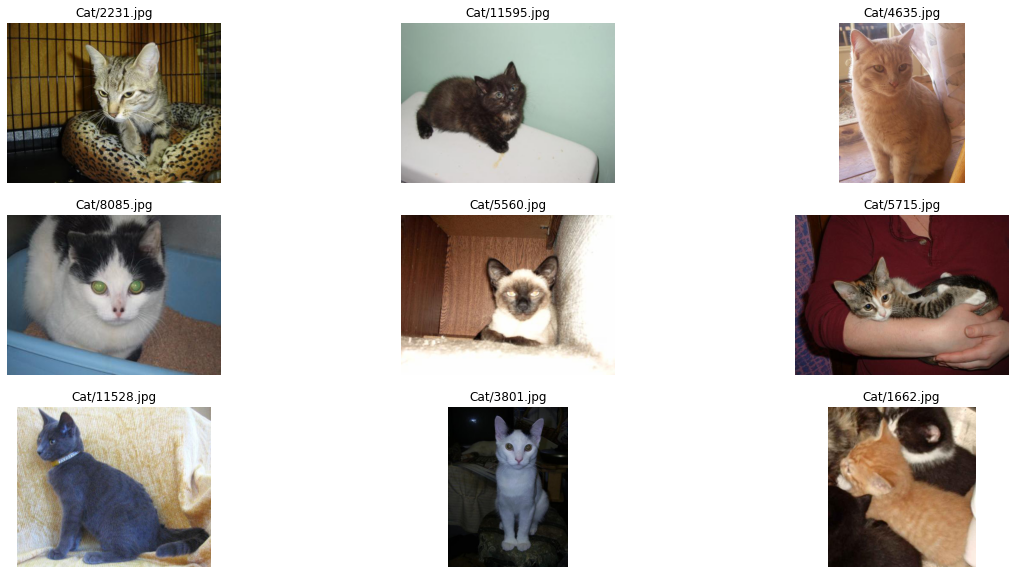

In [ ]:
#Get list of file names
_, _, cat_images = next(os.walk('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Cat'))

fig, ax = plt.subplots(3,3, figsize = (20,10))

#Randomly select and plot an image
for idx, img in enumerate(random.sample(cat_images, 9)):
  img_read = plt.imread('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Cat/' + img)
  ax[int(idx/3), idx%3].imshow(img_read)
  ax[int(idx/3), idx%3].axis('off')
  ax[int(idx/3), idx%3].set_title('Cat/' + img)
plt.show()

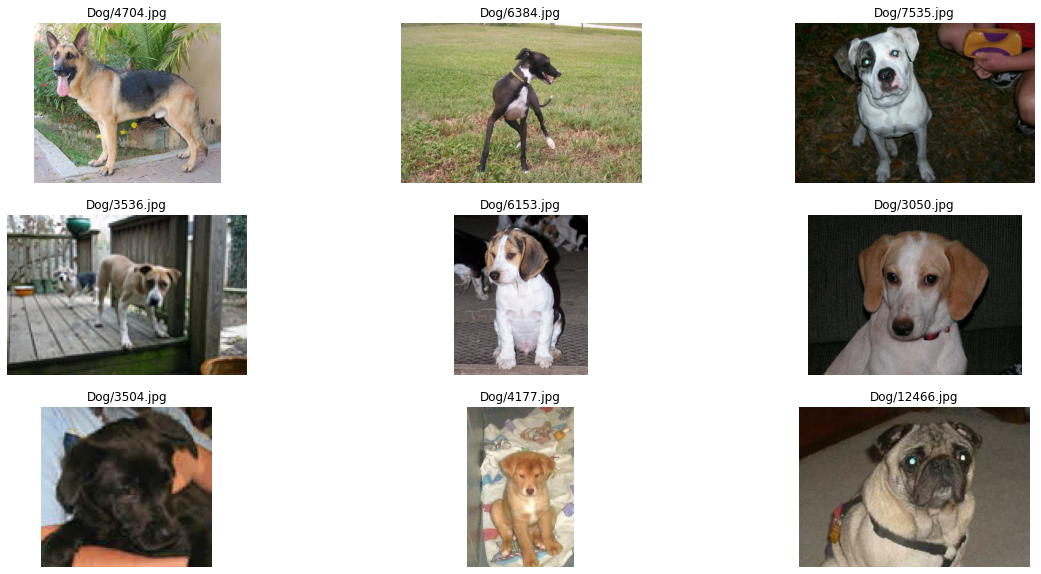

In [ ]:
#Get list of file names
_, _, dog_images = next(os.walk('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Dog'))

fig, ax = plt.subplots(3,3, figsize = (20,10))

#Randomly select and plot an image
for idx, img in enumerate(random.sample(dog_images, 9)):
  img_read = plt.imread('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Dog/' + img)
  ax[int(idx/3), idx%3].imshow(img_read)
  ax[int(idx/3), idx%3].axis('off')
  ax[int(idx/3), idx%3].set_title('Dog/' + img)
plt.show()

In [ ]:
#seperate into testing and training folders

!pip install piexif
import os
import random
import shutil
import piexif

def train_test_split(src_folder, train_size = 0.8):
	# Make sure we remove any existing folders and start from a clean slate
	shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

	# Now, create new empty train and test folders
	os.makedirs(src_folder+'Train/Cat/')
	os.makedirs(src_folder+'Train/Dog/')
	os.makedirs(src_folder+'Test/Cat/')
	os.makedirs(src_folder+'Test/Dog/')

	# Get the number of cats and dogs images
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
	for file in files_to_be_removed:
		cat_images.remove(file)
	num_cat_images = len(cat_images)
	num_cat_images_train = int(train_size * num_cat_images)
	num_cat_images_test = num_cat_images - num_cat_images_train

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	files_to_be_removed = ['Thumbs.db', '11702.jpg']
	for file in files_to_be_removed:
		dog_images.remove(file)
	num_dog_images = len(dog_images)
	num_dog_images_train = int(train_size * num_dog_images)
	num_dog_images_test = num_dog_images - num_dog_images_train

	# Randomly assign images to train and test
	cat_train_images = random.sample(cat_images, num_cat_images_train)
	for img in cat_train_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
	cat_test_images  = [img for img in cat_images if img not in cat_train_images]
	for img in cat_test_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

	dog_train_images = random.sample(dog_images, num_dog_images_train)
	for img in dog_train_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
	dog_test_images  = [img for img in dog_images if img not in dog_train_images]
	for img in dog_test_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

	# remove corrupted exif data from the dataset
	remove_exif_data(src_folder+'Train/')
	remove_exif_data(src_folder+'Test/')

# helper function to remove corrupt exif data from Microsoft's dataset
def remove_exif_data(src_folder):
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	for img in cat_images:
		try:
			piexif.remove(src_folder+'Cat/'+img)
		except:
			pass

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	for img in dog_images:
		try:
			piexif.remove(src_folder+'Dog/'+img)
		except:
			pass



In [ ]:
src_folder = '/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/'
train_test_split(src_folder)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range = 30,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

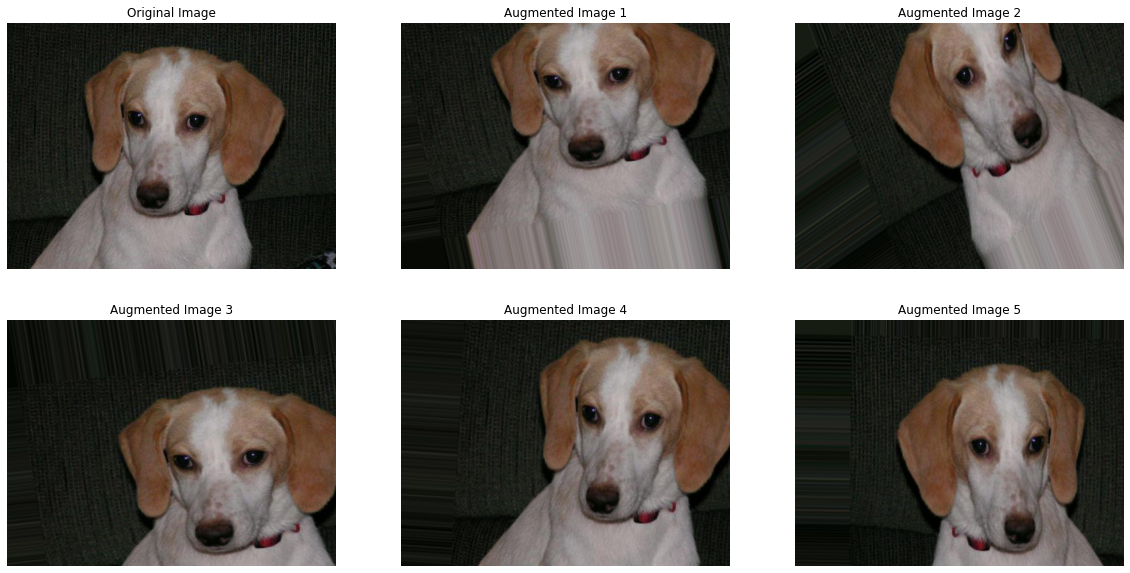

In [ ]:
#Augment randomly selected images from our train/dog folder
fig, ax = plt.subplots(2,3, figsize = (20,10))
all_images = []

_,_,dog_images = next(os.walk('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Train/Dog/' + random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
  augmented_imgs = sample_augmented_images.next()
  for img in augmented_imgs:
    all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
  ax[int(idx/3), idx%3].imshow(img)
  ax[int(idx/3), idx%3].axis('off')
  if idx == 0:
    ax[int(idx/3), idx%3].set_title('Original Image')
  else:
    ax[int(idx/3), idx%3].set_title(f"Augmented Image {idx}")

plt.show()

In [ ]:
#Building a CNN

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

#Declare Hyperparameters
filter_size = 3
num_filters = 32
input_size = 32
maxpool_size = 2
batch_size = 16
steps_per_epoch = 20000//batch_size
epochs = 10

In [ ]:
#Building the CNN architecture
model  = Sequential()
model.add(Conv2D(num_filters, (filter_size, filter_size), input_shape = (input_size, input_size, 3), activation = 'relu'))#First Convolutional Layer
model.add(MaxPool2D(pool_size=(maxpool_size, maxpool_size)))
model.add(Conv2D(num_filters, (filter_size, filter_size), input_shape = (input_size, input_size, 3), activation = 'relu'))#Second Convolutional Layer
model.add(MaxPool2D(pool_size=(maxpool_size, maxpool_size)))#Second Maxpooling Layer
model.add(Flatten()) #flatten the input
model.add(Dense(units = 128, activation='relu')) #our first connected layer
model.add(Dropout(0.5))#set 50% of the weight to 0
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [ ]:
#compile the model
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#training the model
training_data_generator = ImageDataGenerator(rescale= 1./255)
training_set = training_data_generator.flow_from_directory('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Train/', target_size = (input_size, input_size), batch_size = batch_size, class_mode = 'binary')

model.fit_generator(training_set, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose = 1)

Found 19997 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1250/1250 [==============================] - 104s 57ms/step - loss: 0.6754 - accuracy: 0.5678
Epoch 2/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.5578 - accuracy: 0.7189
Epoch 3/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.5168 - accuracy: 0.7399
Epoch 4/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.4742 - accuracy: 0.7747
Epoch 5/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.4427 - accuracy: 0.7864
Epoch 6/10
1250/1250 [==============================] - 70s 56ms/step - loss: 0.4284 - accuracy: 0.8035
Epoch 7/10
1250/1250 [==============================] - 72s 58ms/step - loss: 0.3906 - accuracy: 0.8193
Epoch 8/10
1250/1250 [==============================] - 72s 57ms/step - loss: 0.3698 - accuracy: 0.8355
Epoch 9/10
1250/1250 [==============================] - 71s 57ms/step - loss: 0.3545 - accuracy: 0.8375
Epoch 10/10
1250/1250 [==============================] - 72s 57

In [ ]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Test/', target_size = (input_size, input_size), batch_size = batch_size, class_mode = 'binary')
score = model.evaluate(test_set, steps=len(test_set))
for idx, metric in enumerate(model.metrics_names):
  print(f"{metric}: {score[idx]}")

Found 5000 images belonging to 2 classes.
313/313 [==============================] - 18s 56ms/step - loss: 0.4701 - accuracy: 0.7876
loss: 0.4700508415699005
accuracy: 0.7875999808311462


In [ ]:
#Leveraging pretrained models for transferred learning

from keras.applications.vgg16 import VGG16

input_size=128
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (input_size, input_size, 3))

#freeze layers in vgg16 model
for layer in vgg16.layers:
  layer.trainable = False

#add a fully connected layer 
from keras.models import Model

input_ = vgg16.input
output = vgg16(input_)
last_layer = Flatten(name = 'flatten')(output)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model  = Model(input_, last_layer)

In [ ]:
batch_size = 16
steps_per_epoch = 200
epochs = 3

testing_data_generator = ImageDataGenerator(rescale = 1./255)
test_set = testing_data_generator.flow_from_directory('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Test/', target_size = (input_size, input_size), batch_size = batch_size, class_mode = 'binary')
training_data_generator = ImageDataGenerator(rescale= 1./255)
training_set = training_data_generator.flow_from_directory('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Train/', target_size = (input_size, input_size), batch_size = batch_size, class_mode = 'binary')

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(training_set, steps_per_epoch = steps_per_epoch, epochs=epochs, verbose =1)

Found 5000 images belonging to 2 classes.
Found 19997 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 15s 74ms/step - loss: 0.4478 - accuracy: 0.7730
Epoch 2/3
200/200 [==============================] - 13s 67ms/step - loss: 0.2920 - accuracy: 0.8712
Epoch 3/3
200/200 [==============================] - 14s 68ms/step - loss: 0.2618 - accuracy: 0.8863


In [ ]:
score = model.evaluate(test_set, steps = len(test_set))

for idx, metric in enumerate(model.metrics_names):
  print(f"{metric}: {score[idx]}")

313/313 [==============================] - 21s 67ms/step - loss: 0.2701 - accuracy: 0.8810
loss: 0.2701433002948761
accuracy: 0.8809999823570251


In [ ]:
#Result analysis
test_set = testing_data_generator.flow_from_directory('/content/drive/MyDrive/Cats_vs_dogs/Dataset/PetImages/Test/', target_size = (input_size, input_size), batch_size = batch_size, class_mode = 'binary')

strongly_wrong_idx = []
strongly_right_idx = []
weakly_wrong_idx = []

for i in range(test_set.__len__()):
  img = test_set.__getitem__(i)[0]
  pred_prob = model.predict(img)[0][0]
  pred_label = int(pred_prob > 0.5)
  actual_label = int(test_set.__getitem__(i)[1][0])
  if pred_label != actual_label and (pred_prob > 0.8 or pred_prob < 0.2):
    strongly_wrong_idx.append(i)
  elif pred_label != actual_label and (pred_prob > 0.4 or pred_prob < 0.6):
    weakly_wrong_idx.append(i)
  elif pred_label == actual_label and (pred_prob > 0.8 or pred_prob < 0.2):
    strongly_right_idx.append(i)
  #stop once we have enough images to plot
  if (len(strongly_wrong_idx) >= 9 and len(strongly_right_idx) >= 9 and len(weakly_wrong_idx)>=9):
    break

Found 5000 images belonging to 2 classes.


ValueError: ignored

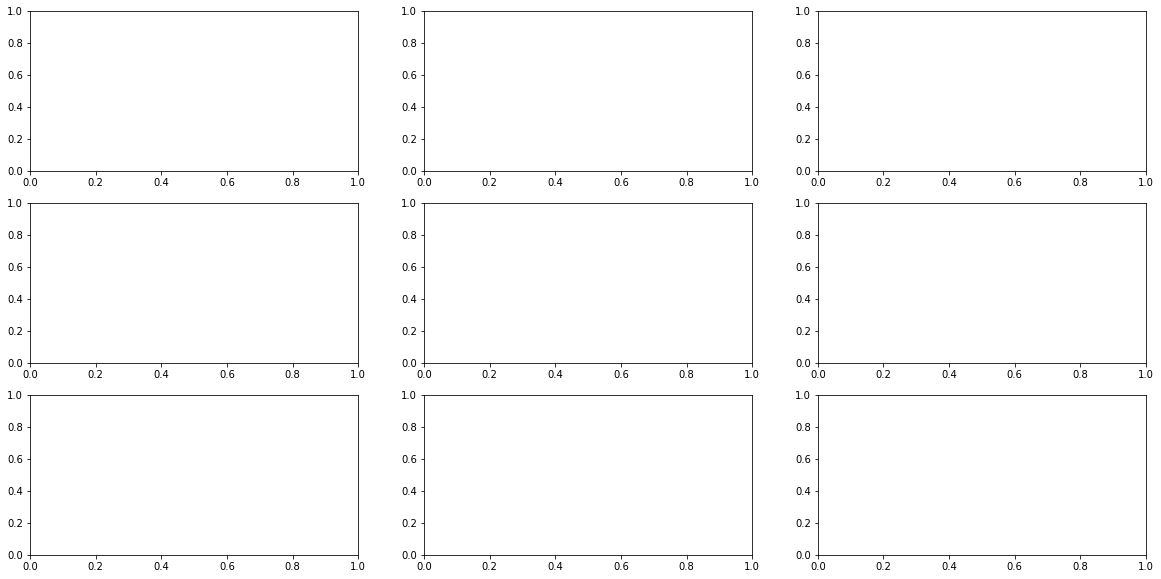

In [ ]:
def plot_on_grid(test_set, idx_to_plot, img_size = input_size):
  fig, ax = plt.subplots(3,3, figsize = (20,10))
  for i, idx in enumerate(random.sample(idx_to_plot, 9)):
    img = test_set.__getitem__(idx)[0].reshape(img_size, img_size, 3)
    ax[int(i/3), i%3].imshow(img)
    ax[int(i/3), i%3].axis('off')

plot_on_grid(test_set, strongly_right_idx)